# Hamiltonian Monte Carlo (HMC) with PyMC

## Introduction

In this notebook, we'll implement the same examples from the Hamiltonian Monte Carlo (HMC) algorithm notebook using PyMC, a probabilistic programming library in Python. PyMC provides a high-level interface for Bayesian modeling and includes efficient implementations of various MCMC algorithms, including HMC and its adaptive variant, the No-U-Turn Sampler (NUTS).

We'll focus on:
1. Sampling from a multivariate normal distribution
2. Bayesian logistic regression

Let's begin by importing the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

## 1. Sampling from a Multivariate Normal Distribution

First, let's recreate the multivariate normal example using PyMC. We'll sample from a 2D normal distribution with mean $\mu = [0, 0]$ and covariance matrix $\Sigma = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}$, where $\rho$ is the correlation coefficient.

In [2]:
# Define parameters for the target distribution
mean = np.array([0, 0])
rho = 0.95  # High correlation to demonstrate HMC's advantage
cov = np.array([[1, rho], [rho, 1]])

# Create PyMC model
with pm.Model() as mvn_model:
    # Define multivariate normal distribution
    x = pm.MvNormal('x', mu=mean, cov=cov)
    
    # Use HMC sampler
    step = pm.HamiltonianMC()
    
    # Sample from the posterior
    trace_hmc = pm.sample(5000, step=step, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [x]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


Now, let's examine the results using ArviZ, a library for exploratory analysis of Bayesian models.

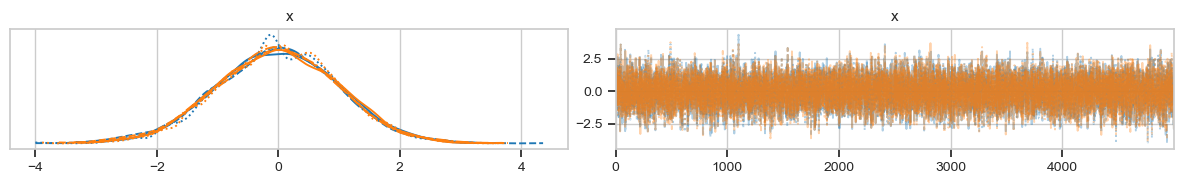

In [3]:
# Plot trace and posterior distributions
az.plot_trace(trace_hmc)
plt.tight_layout()
plt.show()

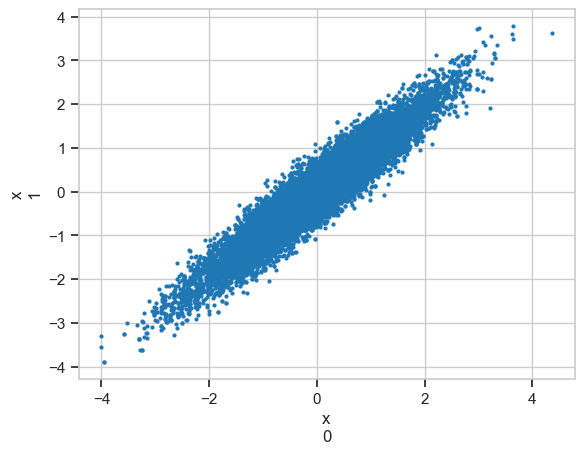

In [4]:
# Plot joint distribution
az.plot_pair(trace_hmc, var_names=['x'], kind='scatter', divergences=True)
plt.show()

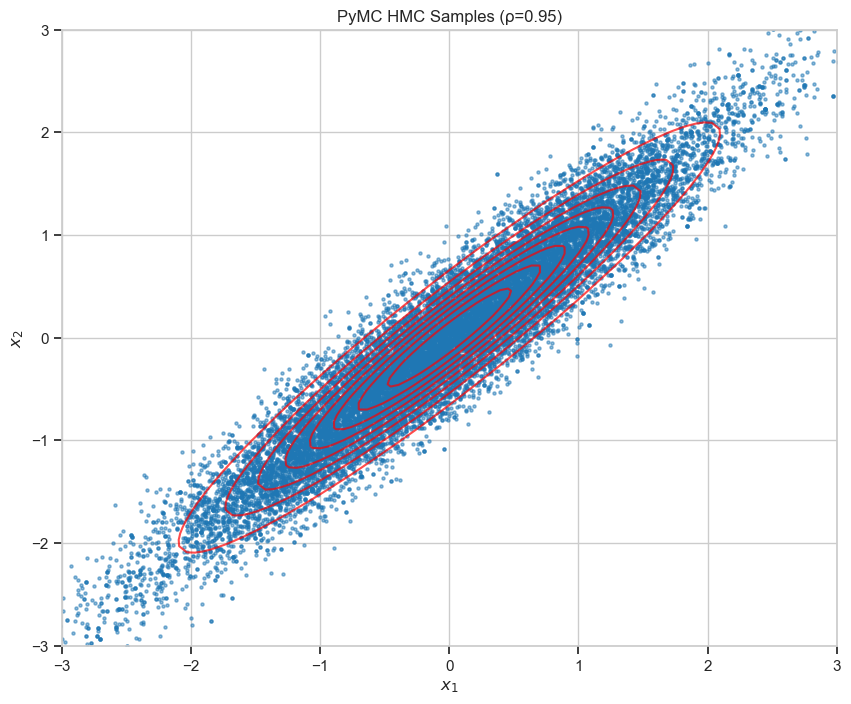

In [5]:
# Extract samples for visualization
pymc_samples = np.vstack([trace_hmc.posterior.x[:, :, 0].values.flatten(), 
                          trace_hmc.posterior.x[:, :, 1].values.flatten()]).T

# Plot the samples
plt.figure(figsize=(10, 8))
plt.scatter(pymc_samples[:, 0], pymc_samples[:, 1], alpha=0.5, s=5)

# Create a grid of points for contour plot
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Compute PDF values on the grid
rv = stats.multivariate_normal(mean, cov)
Z = rv.pdf(pos)

# Plot contours
levels = np.linspace(0, Z.max(), 10)[1:]
plt.contour(X, Y, Z, levels=levels, colors='r', alpha=0.7)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title(f"PyMC HMC Samples (ρ={rho})")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()

### 1.1 Comparison with NUTS

PyMC's default sampler is NUTS (No-U-Turn Sampler), which is an adaptive extension of HMC that automatically tunes the number of leapfrog steps. Let's compare the performance of HMC and NUTS for this problem.

In [6]:
# Create PyMC model with NUTS
with pm.Model() as mvn_model_nuts:
    # Define multivariate normal distribution
    x = pm.MvNormal('x', mu=mean, cov=cov)
    
    # Use NUTS sampler (default)
    trace_nuts = pm.sample(5000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


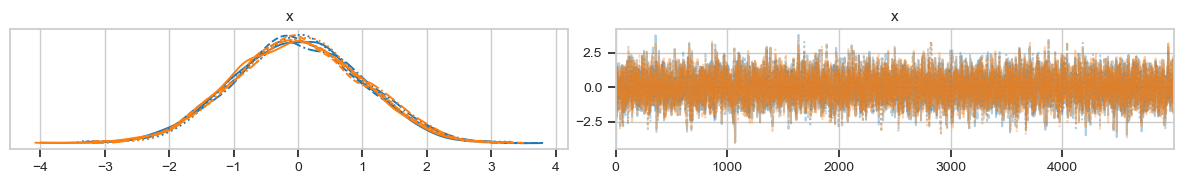

In [7]:
# Plot trace and posterior distributions
az.plot_trace(trace_nuts)
plt.tight_layout()
plt.show()

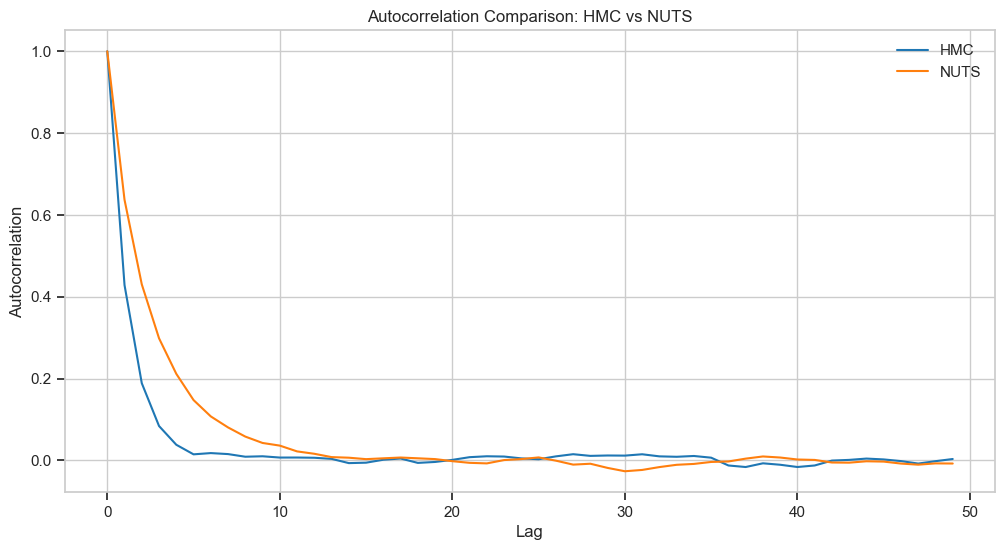

In [8]:
# Compare autocorrelation between HMC and NUTS
plt.figure(figsize=(12, 6))

# Calculate autocorrelation for HMC
hmc_samples = trace_hmc.posterior.x[:, :, 0].values.flatten()
max_lag = 50
hmc_acf = np.zeros(max_lag)
for lag in range(max_lag):
    hmc_acf[lag] = np.corrcoef(hmc_samples[lag:], hmc_samples[:-lag if lag > 0 else None])[0, 1]

# Calculate autocorrelation for NUTS
nuts_samples = trace_nuts.posterior.x[:, :, 0].values.flatten()
nuts_acf = np.zeros(max_lag)
for lag in range(max_lag):
    nuts_acf[lag] = np.corrcoef(nuts_samples[lag:], nuts_samples[:-lag if lag > 0 else None])[0, 1]

plt.plot(range(max_lag), hmc_acf, label='HMC')
plt.plot(range(max_lag), nuts_acf, label='NUTS')
plt.title('Autocorrelation Comparison: HMC vs NUTS')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Compare effective sample size (ESS) between HMC and NUTS
ess_hmc = az.ess(trace_hmc, var_names=['x'])
ess_nuts = az.ess(trace_nuts, var_names=['x'])

# Calculate ESS per sample
n_samples_hmc = len(trace_hmc.posterior.draw)
n_samples_nuts = len(trace_nuts.posterior.draw)

ess_per_sample_hmc = ess_hmc.x.mean().item() / n_samples_hmc
ess_per_sample_nuts = ess_nuts.x.mean().item() / n_samples_nuts

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Sampler': ['HMC', 'NUTS'],
    'ESS': [ess_hmc.x.mean().item(), ess_nuts.x.mean().item()],
    'ESS per Sample': [ess_per_sample_hmc, ess_per_sample_nuts]
})

comparison_df

,Sampler,ESS,ESS per Sample
0,HMC,7641.348230,1.528270
1,NUTS,3787.493224,0.757499


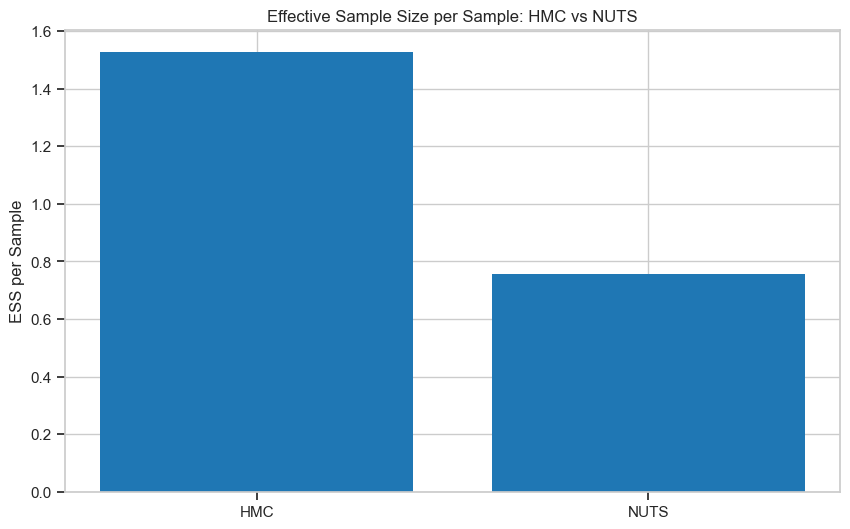

In [10]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Sampler'], comparison_df['ESS per Sample'])
plt.title('Effective Sample Size per Sample: HMC vs NUTS')
plt.ylabel('ESS per Sample')
plt.grid(True, axis='y')
plt.show()

### 1.2 Comparison with Metropolis and Gibbs Sampling

Let's compare the performance of HMC and NUTS with the Metropolis and Gibbs sampling algorithms for the same multivariate normal distribution with high correlation.

In [11]:
# Create PyMC model with Metropolis
with pm.Model() as mvn_model_metropolis:
    # Define multivariate normal distribution
    x = pm.MvNormal('x', mu=mean, cov=cov)
    
    # Use Metropolis sampler
    step = pm.Metropolis()
    trace_metropolis = pm.sample(5000, step=step, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
# Create PyMC model with Gibbs-like approach
with pm.Model() as mvn_model_gibbs:
    # Define x1 and x2 as separate variables
    x1 = pm.Normal('x1', mu=0, sigma=1)
    
    # Define x2 conditionally on x1
    # For a bivariate normal with correlation rho, the conditional distribution is:
    # x2|x1 ~ N(rho*x1, sqrt(1-rho^2))
    x2 = pm.Normal('x2', mu=rho * x1, sigma=np.sqrt(1 - rho**2))
    
    # Create a compound step method that updates each variable separately
    step1 = pm.Metropolis(vars=[x1])
    step2 = pm.Metropolis(vars=[x2])
    
    # Sample using the compound step method
    trace_gibbs = pm.sample(5000, step=[step1, step2], tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [x1]
>Metropolis: [x2]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
# Compare effective sample size (ESS) across all methods
ess_metropolis = az.ess(trace_metropolis, var_names=['x'])
ess_gibbs_x1 = az.ess(trace_gibbs, var_names=['x1'])
ess_gibbs_x2 = az.ess(trace_gibbs, var_names=['x2'])
ess_gibbs_avg = (ess_gibbs_x1.x1.item() + ess_gibbs_x2.x2.item()) / 2

# Calculate ESS per sample
n_samples_metropolis = len(trace_metropolis.posterior.draw)
n_samples_gibbs = len(trace_gibbs.posterior.draw)

ess_per_sample_metropolis = ess_metropolis.x.mean().item() / n_samples_metropolis
ess_per_sample_gibbs = ess_gibbs_avg / n_samples_gibbs

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Sampler': ['Metropolis', 'Gibbs-like', 'HMC', 'NUTS'],
    'ESS': [ess_metropolis.x.mean().item(), ess_gibbs_avg, ess_hmc.x.mean().item(), ess_nuts.x.mean().item()],
    'ESS per Sample': [ess_per_sample_metropolis, ess_per_sample_gibbs, ess_per_sample_hmc, ess_per_sample_nuts]
})

comparison_df

,Sampler,ESS,ESS per Sample
0,Metropolis,224.882372,0.044976
1,Gibbs-like,210.461965,0.042092
2,HMC,7641.348230,1.528270
3,NUTS,3787.493224,0.757499


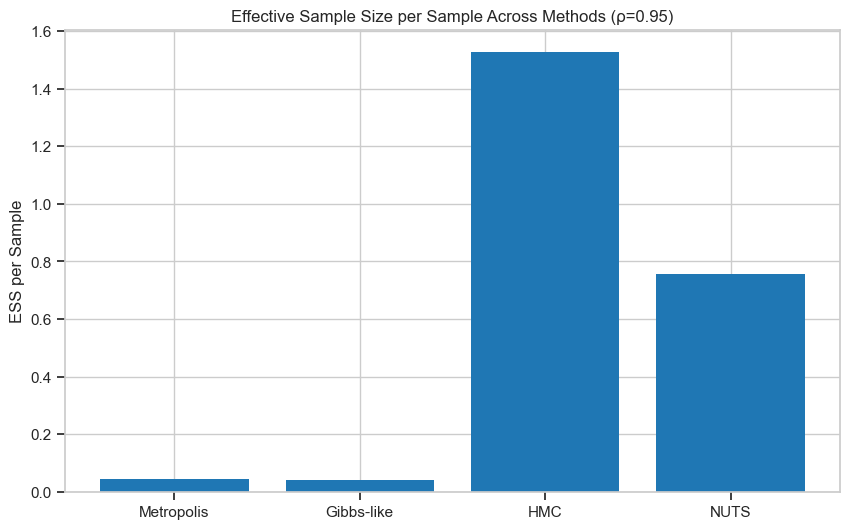

In [14]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Sampler'], comparison_df['ESS per Sample'])
plt.title(f'Effective Sample Size per Sample Across Methods (ρ={rho})')
plt.ylabel('ESS per Sample')
plt.grid(True, axis='y')
plt.show()

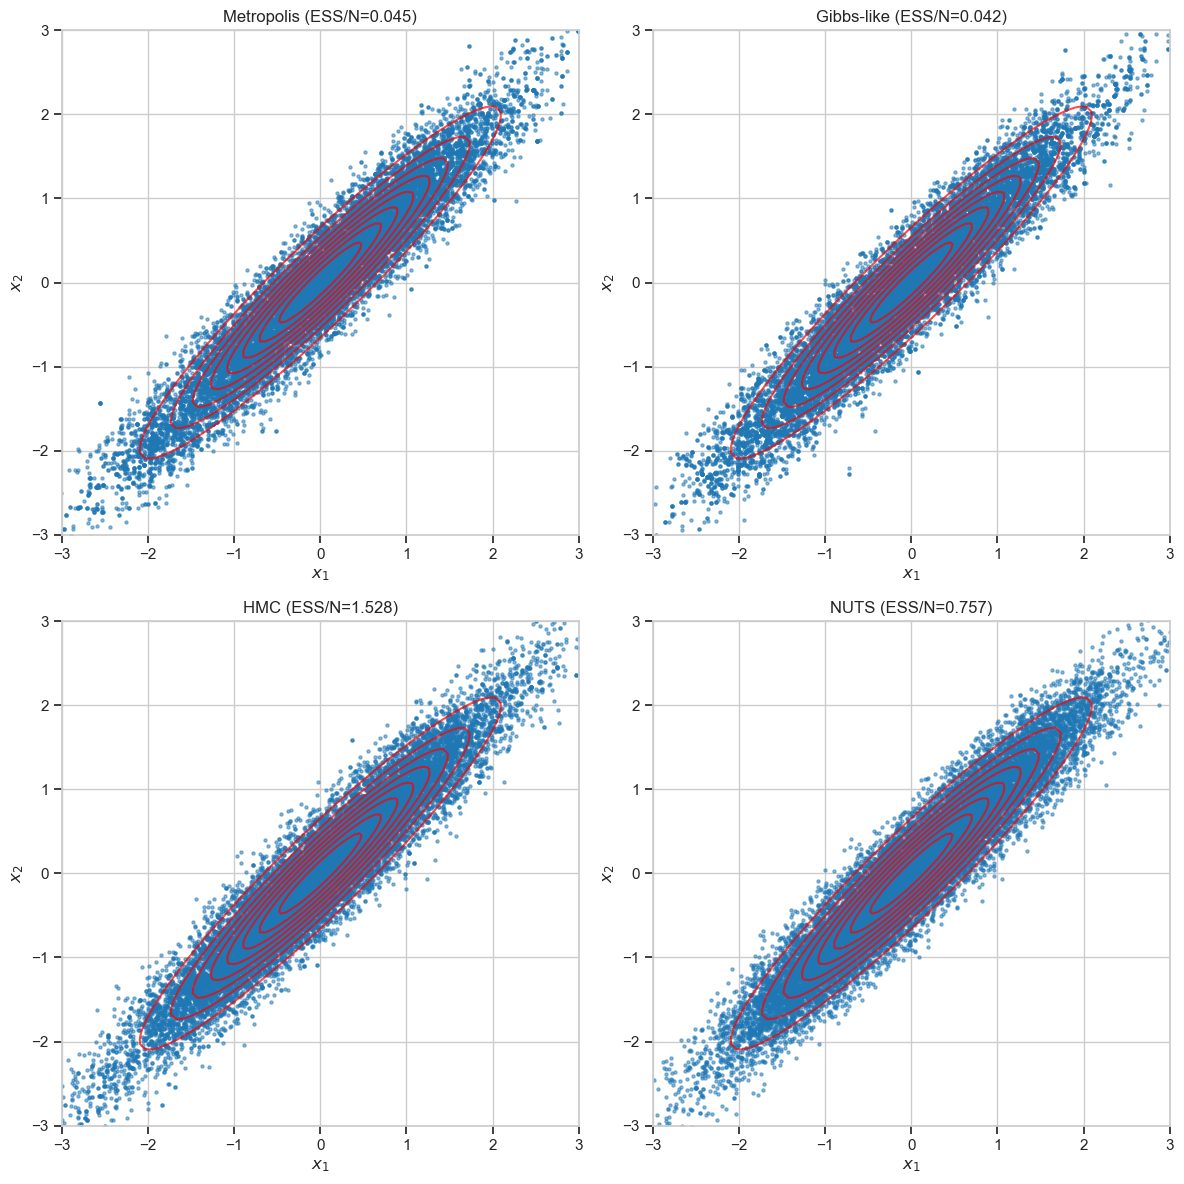

In [15]:
# Plot samples from each method
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Extract samples
metropolis_samples = np.vstack([trace_metropolis.posterior.x[:, :, 0].values.flatten(), 
                               trace_metropolis.posterior.x[:, :, 1].values.flatten()]).T

gibbs_samples = np.vstack([trace_gibbs.posterior.x1.values.flatten(), 
                          trace_gibbs.posterior.x2.values.flatten()]).T

hmc_samples = np.vstack([trace_hmc.posterior.x[:, :, 0].values.flatten(), 
                        trace_hmc.posterior.x[:, :, 1].values.flatten()]).T

nuts_samples = np.vstack([trace_nuts.posterior.x[:, :, 0].values.flatten(), 
                         trace_nuts.posterior.x[:, :, 1].values.flatten()]).T

# Plot samples
axes[0, 0].scatter(metropolis_samples[:, 0], metropolis_samples[:, 1], alpha=0.5, s=5)
axes[0, 0].set_title(f"Metropolis (ESS/N={ess_per_sample_metropolis:.3f})")
axes[0, 0].set_xlim(-3, 3)
axes[0, 0].set_ylim(-3, 3)

axes[0, 1].scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], alpha=0.5, s=5)
axes[0, 1].set_title(f"Gibbs-like (ESS/N={ess_per_sample_gibbs:.3f})")
axes[0, 1].set_xlim(-3, 3)
axes[0, 1].set_ylim(-3, 3)

axes[1, 0].scatter(hmc_samples[:, 0], hmc_samples[:, 1], alpha=0.5, s=5)
axes[1, 0].set_title(f"HMC (ESS/N={ess_per_sample_hmc:.3f})")
axes[1, 0].set_xlim(-3, 3)
axes[1, 0].set_ylim(-3, 3)

axes[1, 1].scatter(nuts_samples[:, 0], nuts_samples[:, 1], alpha=0.5, s=5)
axes[1, 1].set_title(f"NUTS (ESS/N={ess_per_sample_nuts:.3f})")
axes[1, 1].set_xlim(-3, 3)
axes[1, 1].set_ylim(-3, 3)

# Plot contours of the true distribution on all subplots
for ax in axes.flatten():
    ax.contour(X, Y, Z, levels=levels, colors='r', alpha=0.7)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.grid(True)

plt.tight_layout()
plt.show()

## 2. Bayesian Logistic Regression

Now, let's implement the Bayesian logistic regression example using PyMC. We'll use the same synthetic data as in the previous notebook.

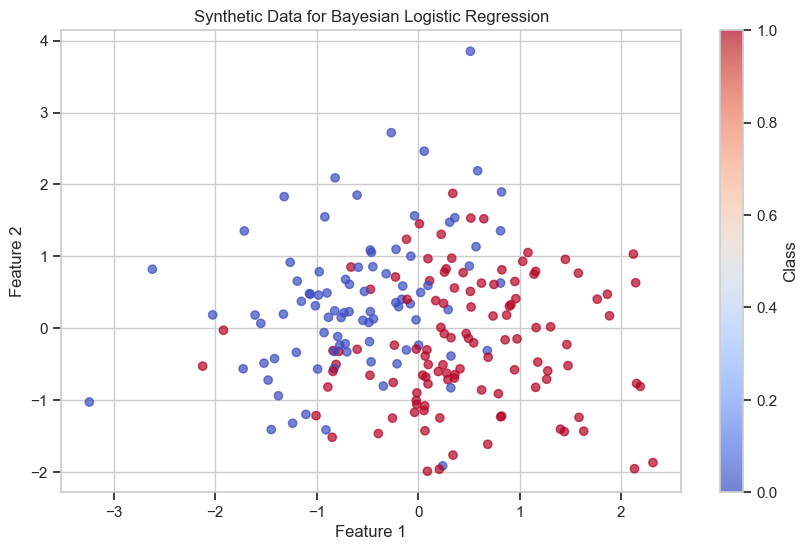

In [16]:
# Set true parameter values
true_beta = np.array([0.5, 2.0, -1.0])  # Intercept and coefficients
n_features = len(true_beta) - 1

# Generate synthetic data
n_data = 200
X = np.random.normal(0, 1, size=(n_data, n_features))
X_with_intercept = np.column_stack([np.ones(n_data), X])
logits = X_with_intercept @ true_beta
p = 1 / (1 + np.exp(-logits))
y = np.random.binomial(1, p)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Data for Bayesian Logistic Regression')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

### 2.1 PyMC Implementation

Let's implement the Bayesian logistic regression model using PyMC. We'll use the same prior as before: $\boldsymbol{\beta} \sim \mathcal{N}(\mathbf{0}, 10^2 \mathbf{I})$.

In [17]:
# Create PyMC model for logistic regression
with pm.Model() as logistic_model:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=0, sigma=10, shape=len(true_beta))
    
    # Expected value of outcome
    mu = pm.math.dot(X_with_intercept, beta)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=pm.math.sigmoid(mu), observed=y)
    
    # Use HMC sampler
    step = pm.HamiltonianMC()
    trace_logistic_hmc = pm.sample(5000, step=step, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [beta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


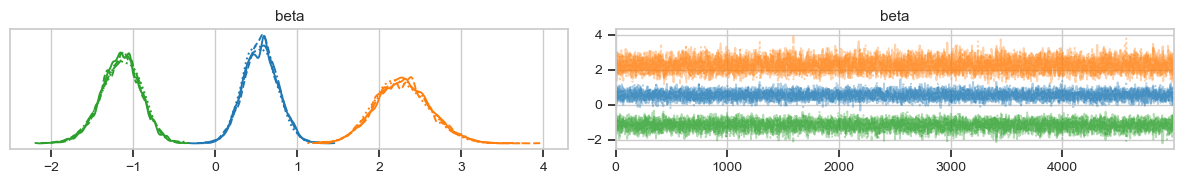

In [18]:
# Plot trace and posterior distributions
az.plot_trace(trace_logistic_hmc)
plt.tight_layout()
plt.show()

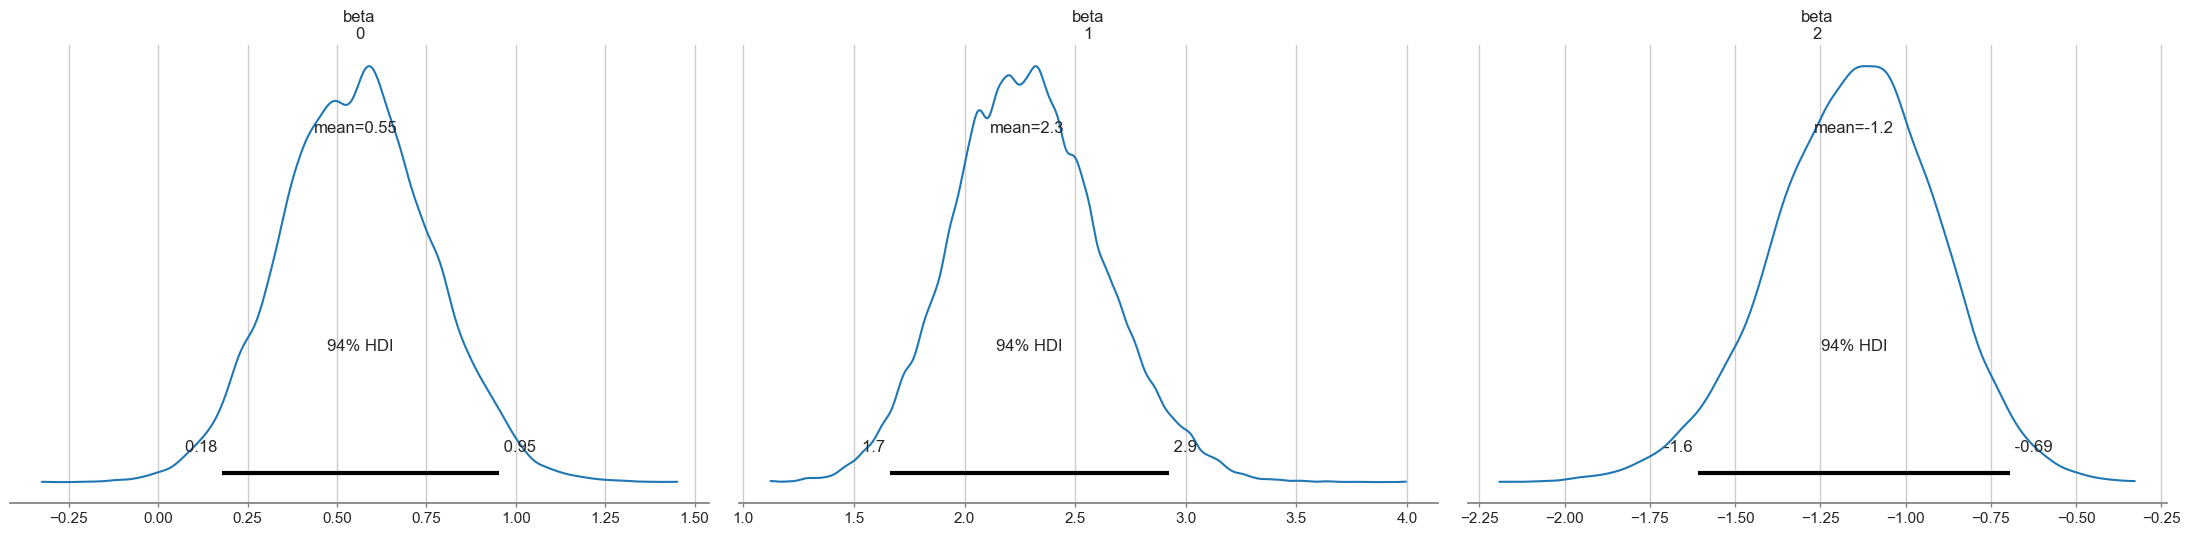

In [20]:
# Plot posterior distributions with true values
az.plot_posterior(trace_logistic_hmc, var_names=['beta'])
plt.tight_layout()
plt.show()

In [21]:
# Summarize posterior statistics
summary = az.summary(trace_logistic_hmc, var_names=['beta'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.553,0.207,0.178,0.952,0.003,0.002,5975.0,8932.0,1.0
beta[1],2.282,0.335,1.663,2.924,0.005,0.003,4906.0,8035.0,1.0
beta[2],-1.151,0.244,-1.610,-0.692,0.003,0.002,5619.0,7453.0,1.0


### 2.2 Comparison with NUTS

Let's compare the performance of HMC with NUTS for the logistic regression problem.

In [22]:
# Create PyMC model for logistic regression with NUTS
with pm.Model() as logistic_model_nuts:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=0, sigma=10, shape=len(true_beta))
    
    # Expected value of outcome
    mu = pm.math.dot(X_with_intercept, beta)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=pm.math.sigmoid(mu), observed=y)
    
    # Use NUTS sampler (default)
    trace_logistic_nuts = pm.sample(5000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


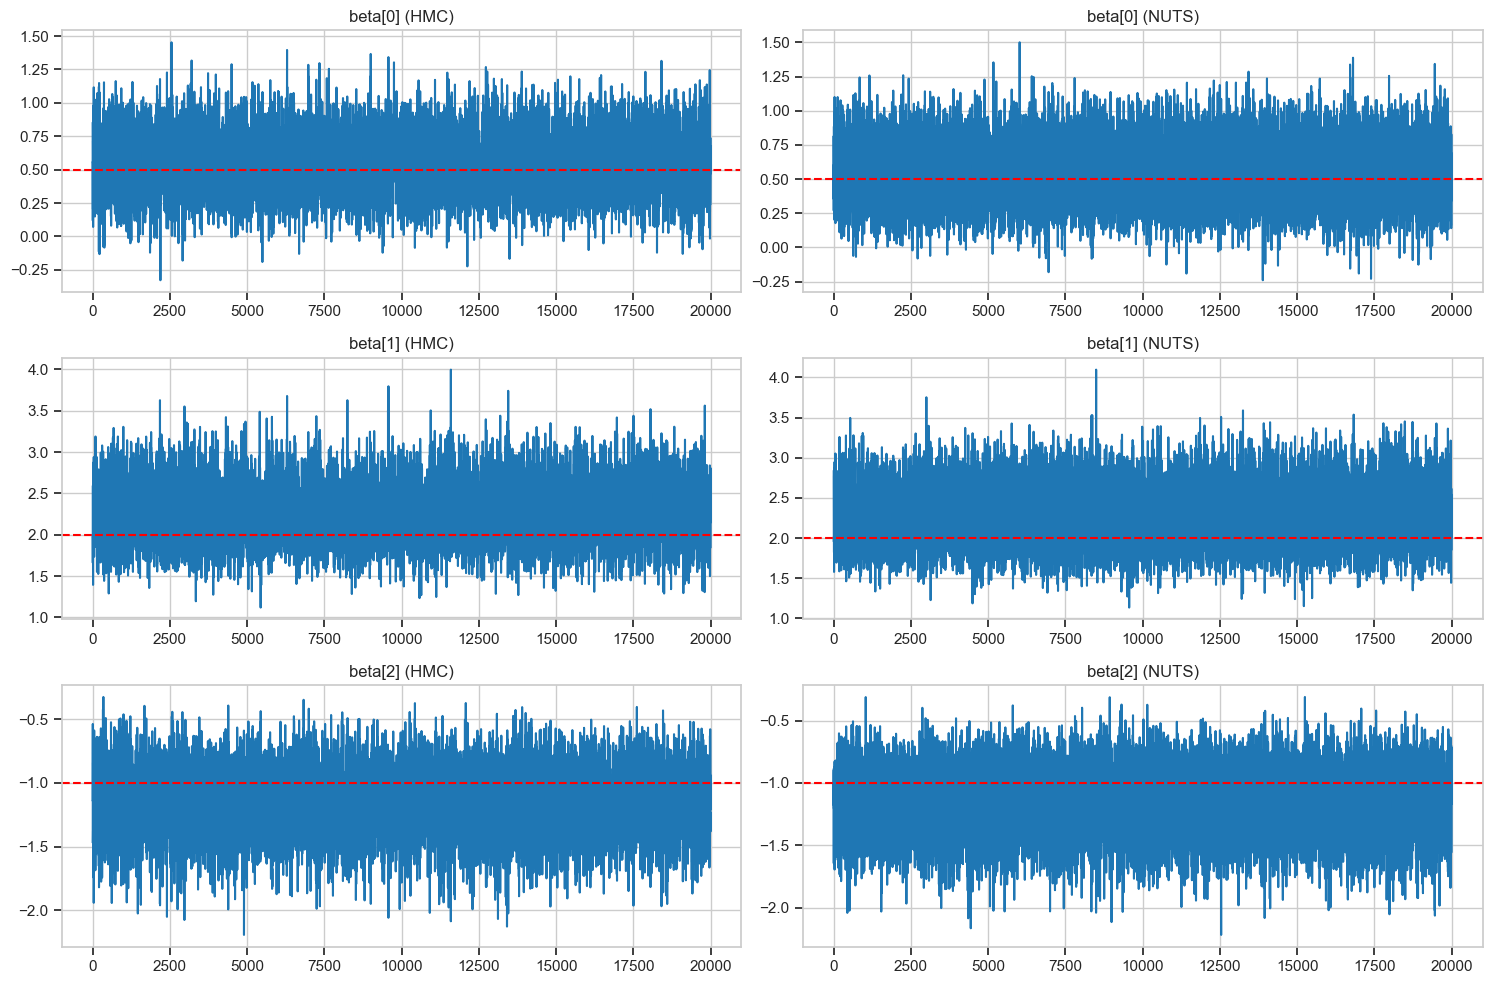

In [23]:
# Compare traces between HMC and NUTS
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Plot HMC traces
for i in range(3):
    samples = trace_logistic_hmc.posterior.beta[:, :, i].values.flatten()
    axes[i, 0].plot(samples)
    axes[i, 0].set_title(f"beta[{i}] (HMC)")
    axes[i, 0].axhline(y=true_beta[i], color='r', linestyle='--')

# Plot NUTS traces
for i in range(3):
    samples = trace_logistic_nuts.posterior.beta[:, :, i].values.flatten()
    axes[i, 1].plot(samples)
    axes[i, 1].set_title(f"beta[{i}] (NUTS)")
    axes[i, 1].axhline(y=true_beta[i], color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [24]:
# Compare effective sample size (ESS) between HMC and NUTS
ess_logistic_hmc = az.ess(trace_logistic_hmc, var_names=['beta'])
ess_logistic_nuts = az.ess(trace_logistic_nuts, var_names=['beta'])

# Calculate ESS per sample
n_samples_logistic_hmc = len(trace_logistic_hmc.posterior.draw)
n_samples_logistic_nuts = len(trace_logistic_nuts.posterior.draw)

ess_per_sample_logistic_hmc = ess_logistic_hmc.beta.mean().item() / n_samples_logistic_hmc
ess_per_sample_logistic_nuts = ess_logistic_nuts.beta.mean().item() / n_samples_logistic_nuts

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Sampler': ['HMC', 'NUTS'],
    'ESS': [ess_logistic_hmc.beta.mean().item(), ess_logistic_nuts.beta.mean().item()],
    'ESS per Sample': [ess_per_sample_logistic_hmc, ess_per_sample_logistic_nuts]
})

comparison_df

,Sampler,ESS,ESS per Sample
0,HMC,5500.221495,1.100044
1,NUTS,15444.098029,3.088820


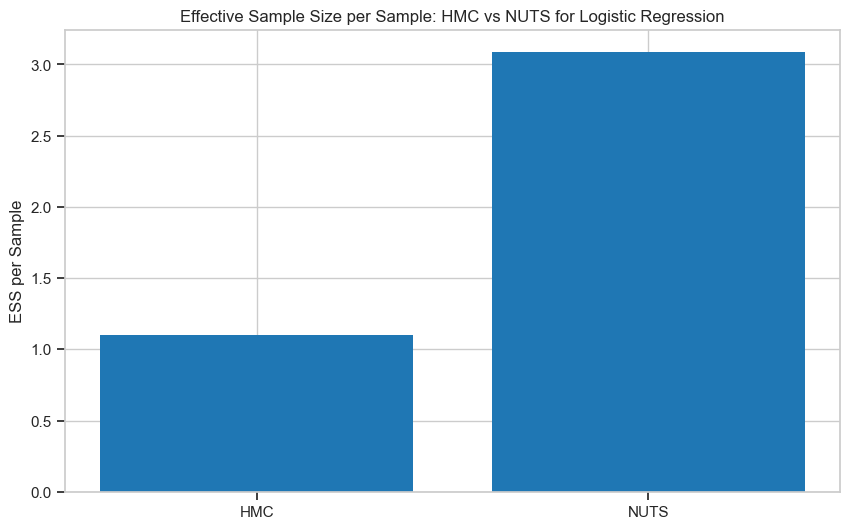

In [25]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Sampler'], comparison_df['ESS per Sample'])
plt.title('Effective Sample Size per Sample: HMC vs NUTS for Logistic Regression')
plt.ylabel('ESS per Sample')
plt.grid(True, axis='y')
plt.show()

### 2.3 Visualizing the Decision Boundary

Let's visualize the decision boundary and posterior uncertainty using the NUTS samples.

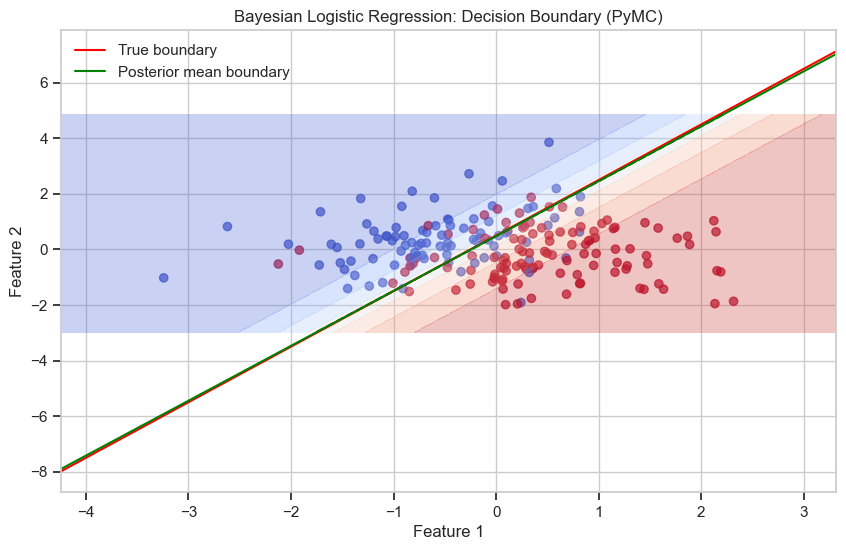

In [26]:
# Extract posterior samples
beta_samples = trace_logistic_nuts.posterior.beta.values.reshape(-1, 3)

# Compute posterior mean
beta_mean = beta_samples.mean(axis=0)

# Plot decision boundary
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)

# Create a grid of points
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
grid = np.c_[xx1.ravel(), xx2.ravel()]

# Compute predicted probabilities for each point in the grid
grid_with_intercept = np.column_stack([np.ones(grid.shape[0]), grid])

# Use posterior mean for prediction
logits = grid_with_intercept @ beta_mean
probs = 1 / (1 + np.exp(-logits))

# Reshape probabilities to grid shape
probs = probs.reshape(xx1.shape)

# Plot decision boundary (p=0.5) and probability contours
plt.contour(xx1, xx2, probs, levels=[0.5], colors='k', linestyles='--')
plt.contourf(xx1, xx2, probs, alpha=0.3, cmap='coolwarm')

# Plot true decision boundary
# For logistic regression, the decision boundary is a line: beta[0] + beta[1]*x1 + beta[2]*x2 = 0
# Solving for x2: x2 = -(beta[0] + beta[1]*x1) / beta[2]
x1_line = np.array([x1_min, x1_max])
x2_line_true = -(true_beta[0] + true_beta[1] * x1_line) / true_beta[2]
plt.plot(x1_line, x2_line_true, 'r-', label='True boundary')

# Plot posterior mean decision boundary
x2_line_mean = -(beta_mean[0] + beta_mean[1] * x1_line) / beta_mean[2]
plt.plot(x1_line, x2_line_mean, 'g-', label='Posterior mean boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Bayesian Logistic Regression: Decision Boundary (PyMC)')
plt.legend()
plt.grid(True)
plt.show()

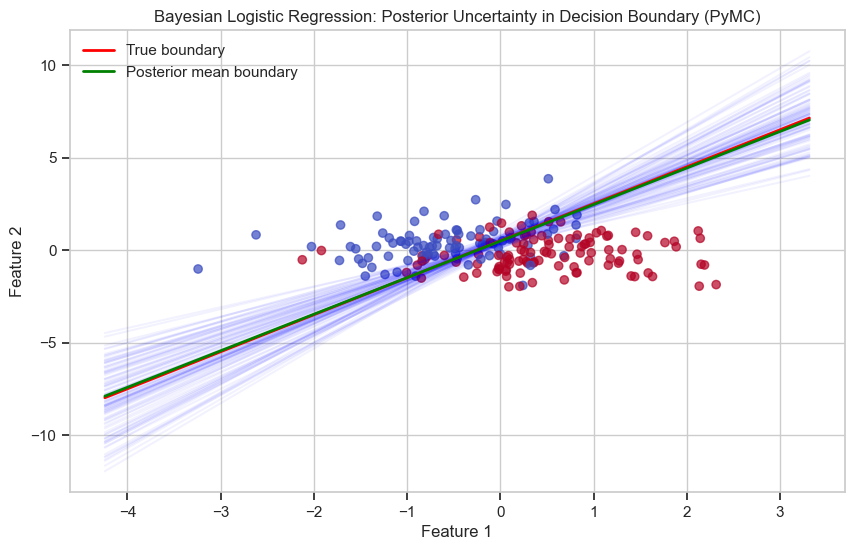

In [27]:
# Plot posterior uncertainty in decision boundary
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)

# Plot a sample of decision boundaries from the posterior
n_samples_to_plot = 100
sample_indices = np.random.choice(len(beta_samples), n_samples_to_plot, replace=False)

for idx in sample_indices:
    beta_sample = beta_samples[idx]
    x2_line_sample = -(beta_sample[0] + beta_sample[1] * x1_line) / beta_sample[2]
    plt.plot(x1_line, x2_line_sample, 'b-', alpha=0.05)

# Plot true decision boundary
plt.plot(x1_line, x2_line_true, 'r-', linewidth=2, label='True boundary')

# Plot posterior mean decision boundary
plt.plot(x1_line, x2_line_mean, 'g-', linewidth=2, label='Posterior mean boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Bayesian Logistic Regression: Posterior Uncertainty in Decision Boundary (PyMC)')
plt.legend()
plt.grid(True)
plt.show()